In [1]:
import xarray as xr
import geopandas as gpd

from shapely.geometry import Point, Polygon

import time

import matplotlib.pyplot as plt

coastline  = gpd.read_file('/Users/iatake/Dropbox (CMCC)/Work/MEDSLIK-II and Pyslick/Medslik-II/data/gshhs/GSHHS_shp/f/GSHHS_f_L1.shp')

# Support for Marco Seracini

## Create a Line shapefile

In [79]:
def split_line(line, distance):
    if line.length <= distance:
        return [line]
    
    num_segments = int(line.length / distance)
    segments = []
    for i in range(num_segments):
        start_dist = i * distance
        end_dist = (i + 1) * distance
        segment = line.interpolate(start_dist).buffer(distance).intersection(line)
        segments.append(segment)
    
    # Add the last segment
    segment = line.interpolate((i + 1) * distance).intersection(line)
    segments.append(segment)
    
    return segments

In [45]:
xmin = 33
xmax = 36
ymin = 33
ymax = 35

# Cropping to a smaller area
lines = coastline.cx[xmin:xmax, ymin:ymax]

#shp with linestring instead of polygons
lines['geometry'] = lines.geometry.boundary

# Cropping the selected linestrings to the same bounding box
lines = lines.clip_by_rect(xmin,ymin, xmax,ymax)

# Removing empty geometries
lines = lines[~lines.is_empty]

#Transforming it back again to geodataframe
lines = gpd.GeoDataFrame(geometry = lines)

#removing any multiline strings left on the shapefile
lines = lines.explode(index_parts=True)

lines = lines.reset_index()

lines['geom'] = lines.geometry

/Users/iatake/anaconda3/envs/ig/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [98]:
new_lines = []
for index, row in lines.iterrows():
    line = row['geometry']
    segments = split_line(line, 0.005)
    for segment in segments:
        new_lines.append(segment)

new_gdf = gpd.GeoDataFrame(geometry=new_lines)
new_gdf['geom'] = new_gdf.geometry


In [99]:
new_gdf

,geometry,geom
0,"LINESTRING (35.08433 33.00000, 35.08614 33.001...","LINESTRING (35.08433 33.00000, 35.08614 33.001..."
1,"LINESTRING (35.08433 33.00000, 35.08614 33.001...","LINESTRING (35.08433 33.00000, 35.08614 33.001..."
2,"LINESTRING (35.08614 33.00394, 35.08614 33.004...","LINESTRING (35.08614 33.00394, 35.08614 33.004..."
3,"LINESTRING (35.08700 33.00846, 35.08700 33.009...","LINESTRING (35.08700 33.00846, 35.08700 33.009..."
4,"LINESTRING (35.08865 33.01277, 35.08867 33.013...","LINESTRING (35.08865 33.01277, 35.08867 33.013..."
...,...,...
1108,"LINESTRING (35.76464 34.49489, 35.76508 34.495...","LINESTRING (35.76464 34.49489, 35.76508 34.495..."
1109,"LINESTRING (35.80547 34.44656, 35.80583 34.446...","LINESTRING (35.80547 34.44656, 35.80583 34.446..."
1110,"LINESTRING (35.80464 34.44822, 35.80506 34.448...","LINESTRING (35.80464 34.44822, 35.80506 34.448..."
1111,"LINESTRING (35.75717 34.49819, 35.75753 34.498...","LINESTRING (35.75717 34.49819, 35.75753 34.498..."


## Get values from a output timestep

In [4]:
output = xr.open_dataset('temp/spill_properties_Marco.nc')

rec = output.isel(time = 140)

geom = []
volume = []

for p in range(0,len(rec.non_evaporative_volume)):

    if rec.particle_status[p].values < 0:
        geom.append(Point(rec.isel(parcel_id=p).longitude.values,rec.isel(parcel_id=p).latitude.values))
        volume.append(rec.isel(parcel_id=p).non_evaporative_volume.values)
    else:
        pass

In [5]:
shp = gpd.GeoDataFrame(data=volume,columns=['oil_volume'],geometry=geom,crs=4326)

In [6]:
shp

,oil_volume,geometry
0,0.282867,POINT (35.46811 33.89129)
1,0.197620,POINT (35.47954 33.87684)
2,0.261147,POINT (35.46869 33.89698)
3,0.246236,POINT (35.47185 33.88426)
4,0.291160,POINT (35.46743 33.89199)
...,...,...
17936,4.164224,POINT (35.47156 33.78109)
17937,4.327546,POINT (35.46841 33.77713)
17938,4.327546,POINT (35.46452 33.77037)
17939,4.241444,POINT (35.44789 33.74733)


<Axes: >

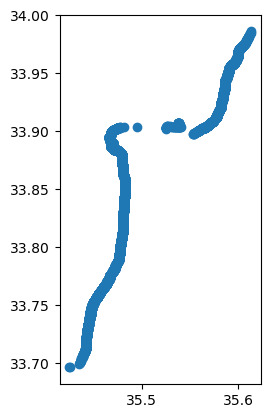

In [7]:
shp.plot()

<Axes: >

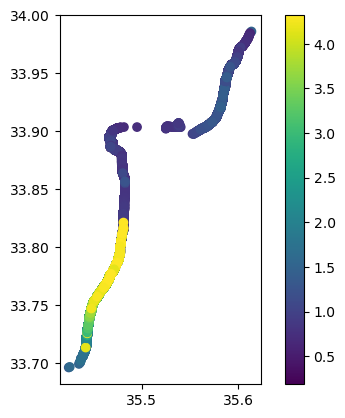

In [8]:
shp.plot(column='oil_volume',legend=True)


<Axes: >

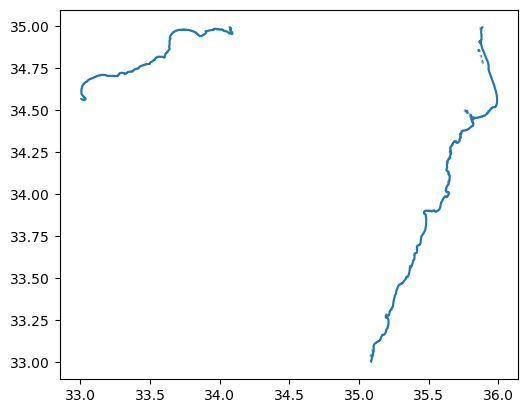

In [47]:
lines.plot()

In [100]:
# join = gpd.sjoin_nearest(shp,lines,how='left')
join = gpd.sjoin_nearest(shp,new_gdf,how='left')

/var/folders/k4/jt3tnjj96t551zphcp5z9t5w0000gp/T/ipykernel_97250/4078854856.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  join = gpd.sjoin_nearest(shp,new_gdf,how='left')
/Users/iatake/anaconda3/envs/ig/lib/python3.11/site-packages/geopandas/array.py:365: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [101]:
join

,oil_volume,geometry,index_right,geom
0,0.282867,POINT (35.46811 33.89129),236,"LINESTRING (35.47198 33.88412, 35.46997 33.886..."
0,0.282867,POINT (35.46811 33.89129),237,"LINESTRING (35.46787 33.88695, 35.46789 33.887..."
1,0.197620,POINT (35.47954 33.87684),231,"LINESTRING (35.48037 33.86789, 35.48036 33.870..."
2,0.261147,POINT (35.46869 33.89698),238,"LINESTRING (35.46835 33.89105, 35.46700 33.892..."
2,0.261147,POINT (35.46869 33.89698),239,"LINESTRING (35.46661 33.89532, 35.46744 33.896..."
...,...,...,...,...
17938,4.327546,POINT (35.46452 33.77037),208,"LINESTRING (35.45932 33.76385, 35.46117 33.765..."
17938,4.327546,POINT (35.46452 33.77037),209,"LINESTRING (35.46263 33.76719, 35.46286 33.767..."
17939,4.241444,POINT (35.44789 33.74733),202,"LINESTRING (35.44622 33.73944, 35.44622 33.741..."
17939,4.241444,POINT (35.44789 33.74733),203,"LINESTRING (35.44703 33.74408, 35.44703 33.744..."


In [95]:
join.groupby('index_right').sum('oil_volume')

,oil_volume
index_right,
189,2.964816
190,1.365398
191,1.510924
192,7.861864
193,38.940285
...,...
282,17.815481
283,7.729180
284,1.209210


<Axes: >

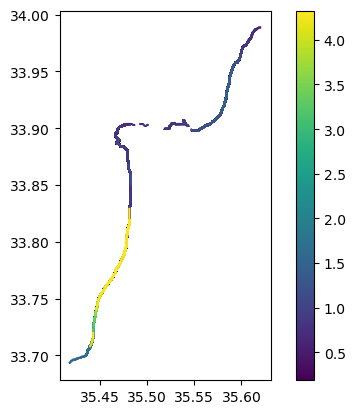

In [103]:
join['geometry'] = join.geom
join.plot(column = 'oil_volume',legend=True)